Author: Sri Sai Charan Velisetti

In [1]:
## Import necessary libraries here (You can add libraries you want to use here)
from skimage.util import img_as_float
from skimage import io, color
from skimage import draw
import matplotlib.pyplot as plt
import argparse, time
import math, copy
import numpy as np
import scipy.io
import cv2
from sklearn import mixture
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow
import os
import timeit


In [2]:
def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray() 
    plt.axis('off')
    plt.show()



# SLIC Superpixels

## Overview

Superpixel algorithms group pixels into perceptually meaningful regions while respecting potential object contours, and thereby can replace the rigid pixel grid structure. Due to the reduced complexity, superpixels are becoming popular for various computer vision applications, e.g., multiclass object segmentation, depth estimation, human pose estimation, and object localization.

In this problem, you will implement a simple superpixel algorithm called Simple Linear Iterative Clustering (SLIC) that clusters pixels in the five-dimensional color and pixel coordinate space (e.g., r, g, b, x, y). The algorithm starts with a collection of K cluster centers initialized at an equally sampled regular grid on the image of N pixels. For each cluster, you define for a localized window 2S x 2S centered at the cluster center, where S = sqrt(N/K) is the roughly the space between the seed cluster centers. Then, you check whether the pixel within the 2S x 2S local window should be assigned to the cluster center or not (by comparing the distance in 5D space to the cluster center). Once you loop through all the clusters, you can update the cluster center by averaging over the cluster members. Iterate the pixel-to-cluster assignment process till convergence or maximum iterations reached.

Reference Paper: http://www.kev-smith.com/papers/SMITH_TPAMI12.pdf

refer to the following slide covered in Lecture_17_Segmentation.pptx here: https://drive.google.com/file/d/1bRmNBXgK1_kWcY-nhw_As5fP10aRhuDC/view?usp=share_link






## Data
**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
!unzip "/content/Part1_SLIC.zip" -d "/content/"

## Helper Functions:

### Code 

In [4]:
# A class to initialize the super pixels, of the form - [l,a,b,h,w].
class SuperPixel(object):

    def __init__(self, l=0, a=0, b=0, h=0, w=0):
        self.update(l, a, b, h, w)
        self.pixels = []

    def update(self, l, a, b, h, w):
        self.l = l
        self.a = a
        self.b = b
        self.h = h
        self.w = w

# Function which returns an object of class SuperPixel
def make_SuperPixel(h, w,img):
    return SuperPixel(img[h,w][0],img[h,w][1],img[h,w][2], h, w)

def display_clusters(img, clusters):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        image[c.h, c.w][0] = 0
        image[c.h, c.w][1] = 0
        image[c.h, c.w][2] = 0
    rgb_arr = color.lab2rgb(image) 
    show_image(rgb_arr)

In [5]:
def initialize_cluster_centers(S, image, img_h, img_w, clusters):
    #### Write your code here ####
    # To Do: Initialize "clusters" by sampling pixels at an equally sampled regular grid (distanced by S)
    # on the image of N pixels. N = img_h X img_w. Hint: clusters.append(make_superPixel(h, w, image)) to create each cluster/super-pixel.
    for h in range(int(S/2),img_h,S):
      for w in range(int(S/2),img_w,S):
        clusters.append(make_SuperPixel(h,w,image))
    return clusters

def get_gradient(h, w,image):
    if w + 1 >= image.shape[1]:
        w = image.shape[1] - 2
    if h + 1 >= image.shape[0]:
        h = image.shape[0] - 2
    gradientx = np.sqrt((image[h][w+1][0] - image[h][w-1][0])**2 + (image[h][w+1][1] - image[h][w-1][1])**2 + (image[h][w+1][2] - image[h][w-1][2])**2)
    gradienty = np.sqrt((image[h+1][w][0] - image[h-1][w][0])**2 + (image[h+1][w][1] - image[h-1][w][1])**2 + (image[h+1][w][2] - image[h-1][w][2])**2)
    gradient = gradientx + gradienty
    return gradient

def relocate_cluster_center_at_lowgrad(clusters, image):
    #### Write your code here ####
    # To Do:
    # for each cluster c, reassign cluster to the pixel having smallest gradient value.
    # Step 1: compute gradient wrt cluster-center c.h, c.w in 3X3 neighborhood of cluster center.
    # Step 2: Similarly, compute gradient for each pixel in 3X3 spatial neighborhood of cluster c.
    # Step 3. Reassign cluster-center to the pixel (x,y) having the lowest gradient. 
    # Hint: c.update(img[x,y][0], img[h,w][1], img[x,y][2], x, y)
    # print(image.shape)
    for c in clusters:
      gradient = get_gradient(c.h,c.w,image)
      for h in range(-1, 2):
          for w in range(-1, 2):
              x = c.h + h
              y = c.w + w
              new_gradient = get_gradient(x, y,image)
              if new_gradient < gradient:
                  c.update(image[x][y][0], image[x][y][1], image[x][y][2],x,y)
                  gradient = new_gradient

    return None

In [6]:
def assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis,M):
    #### Write your code here ####
    # To Do: Compare each pixel to cluster center within 2S pixel distance and assign to nearest cluster using the "distance metric"
    # (involving both color and spatial dimensions of pixel and cluster, 
    # Hints: 
    # 1. use "dis" matrix for comparing distances.
    # 2. You can use c.pixels.append((h, w)) to keep track of cluster-assignments.
    # iter_list = itertools.product(range(0,img_h),range(0,img_w),clusters)
    # for h,w,c in itertools.product(range(0,img_h),range(0,img_w),clusters):
    for c in clusters:
      for h in range(c.h - 2 * S, c.h + 2 * S):
          if h < 0 or h >= img_h: continue
          for w in range(c.w - 2 * S, c.w + 2 * S):
              if w < 0 or w >= img_w: continue
              l, a, b = image[h,w]
              Dc = np.sqrt((l - c.l)**2 + (a - c.a)**2 + (b - c.b)**2)
              Ds = np.sqrt((h - c.h)**2 + (w - c.w)**2)
              D = np.sqrt((Dc / M)**2 + (Ds /S)**2)
              if D < dis[h,w]:
                  if (h, w) not in cluster_tag:
                      cluster_tag[(h, w)] = c
                      c.pixels.append((h, w))
                  else:
                      cluster_tag[(h, w)].pixels.remove((h, w))
                      cluster_tag[(h, w)] = c
                      c.pixels.append((h, w))
                  dis[h, w] = D

            
    return None

In [7]:
def update_clusters(clusters,image):
    # To Do: For each cluster, update the cluster center with mean of the pixels assigned (c.pixels)
    # for cluster in clusters:
    for c in clusters:
      sum_h,sum_w = 0,0
      for pixel in c.pixels:
        sum_h += pixel[0]
        sum_w += pixel[1]
      mean_h = sum_h // len(c.pixels)
      mean_w = sum_w // len(c.pixels)
      c.update(image[mean_h, mean_w][0],image[mean_h, mean_w][1],image[mean_h, mean_w][2], mean_h, mean_w)
    return None

In [8]:
def compute_res_error(old_clusters, new_clusters):
    error = 0.0
    # error = Compute L1 distance between previous cluster-centres and new cluster centers.
    for new_c,old_c in zip(new_clusters,old_clusters):
        error_lab = np.abs(new_c.l - old_c.l) + np.abs(new_c.a - old_c.a) + np.abs(new_c.b - old_c.b)
        error_hw = np.abs(new_c.h - old_c.h) + np.abs(new_c.w - old_c.w)
        error += error_lab + error_hw
    return error

In [9]:
def slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M):

    # Initialize cluster centers on pixel grid in steps S
    clusters = initialize_cluster_centers(S, image, img_h, img_w, clusters)

    # Move centers to position in 3x3 window with smallest gradient.
    relocate_cluster_center_at_lowgrad(clusters, image)

    # You can play around with these hyper-params.
    res_err = 123456789.0 # init residual_error with a very large value (choose as per your understanding.)
    threshold = 0.01 # tune this

    while(res_err >= threshold):

      assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis, M)
      old_clusters = copy.deepcopy(clusters)
      update_clusters(clusters,image)

      res_err = compute_res_error(old_clusters, clusters)
      if res_err<threshold:
        break
    
    return clusters    


In [10]:
# Main Block:

img_path = "/content/Part1_SLIC/BSD_data/images/10081.jpg"

# Load image and convert it from an unsigned 8-bit integer to a floating point data type.
image = img_as_float(io.imread(img_path))

# convert RGB to LAB
image = color.rgb2lab(image)
img_h = image.shape[0] #  Height
img_w = image.shape[1] #  Width

# k: Number of clusters/superpixels.
k = 1024
N = img_h * img_w  # Total pixels in the image
S = int(math.sqrt(N /k)) # Average size of each superpixel
M = 2
clusters = []
cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M)


time: 5min 58s (started: 2022-11-24 03:22:17 +00:00)


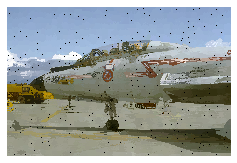

k : 1024  M : 2 
time: 308 ms (started: 2022-11-24 03:28:16 +00:00)


In [11]:
display_clusters(image, clusters)
print("k : 1024", " M : 2 ")

In [12]:
img_path = "/content/Part1_SLIC/BSD_data/images/10081.jpg"

# Load image and convert it from an unsigned 8-bit integer to a floating point data type.
image = img_as_float(io.imread(img_path))

# convert RGB to LAB
image = color.rgb2lab(image)
img_h = image.shape[0] #  Height
img_w = image.shape[1] #  Width

# k: Number of clusters/superpixels.
k = 256
N = img_h * img_w  # Total pixels in the image
S = int(math.sqrt(N /k)) # Average size of each superpixel
M = 10 #Compactness of the cluster pixel
clusters = []
cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M)

time: 3min 44s (started: 2022-11-24 03:28:16 +00:00)


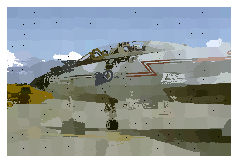

k : 1024  M : 10 
time: 330 ms (started: 2022-11-24 03:32:00 +00:00)


In [13]:
display_clusters(image, clusters)
print("k : 1024", " M : 10 ")

In [29]:
img_path = "/content/Part1_SLIC/BSD_data/images/10081.jpg"

# Load image and convert it from an unsigned 8-bit integer to a floating point data type.
image = img_as_float(io.imread(img_path))

# convert RGB to LAB
image = color.rgb2lab(image)
img_h = image.shape[0] #  Height
img_w = image.shape[1] #  Width

# k: Number of clusters/superpixels.
k = 64
N = img_h * img_w  # Total pixels in the image
S = int(math.sqrt(N /k)) # Average size of each superpixel
M = 40 #Compactness of the cluster pixel
clusters = []
cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M)

time: 3min 20s (started: 2022-11-24 04:00:13 +00:00)


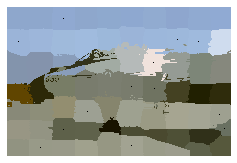

k : 1024  M : 40 
time: 302 ms (started: 2022-11-24 04:03:33 +00:00)


In [30]:
display_clusters(image, clusters)
print("k : 1024", " M : 40 ")

In [10]:
images_list = os.listdir("/content/Part1_SLIC/BSD_data/images")
for im in images_list[:10]:
  run_time_list = []
  for k in (64,256,1024):
    img_path = "/content/Part1_SLIC/BSD_data/images/" + im

    image = img_as_float(io.imread(img_path))
    image = color.rgb2lab(image)
    img_h = image.shape[0] #  Height
    img_w = image.shape[1] #  Width
    N = img_h * img_w  # Total pixels in the image
    S = int(math.sqrt(N /k)) # Average size of each superpixel

    clusters = []
    cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
    dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.
    start = timeit.default_timer()
    clusters1 = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M=15)
    stop = timeit.default_timer()
    run_time = stop - start
    # print("Run time for image :  ",im,"hyperparameter K: ",k," : runtime : ",run_time," seconds")
    run_time_list.append(run_time)
  avg_runtime = np.mean(run_time_list)
  print("Avg Run-time of image ",im," hyperparameter K: 64,256,1024 : runtime : ",avg_runtime,"seconds\n")

Avg Run-time of image  49024.jpg  hyperparameter K: 64,256,1024 : runtime :  93 seconds

Avg Run-time of image  10081.jpg  hyperparameter K: 64,256,1024 : runtime :  110 seconds

Avg Run-time of image  14085.jpg  hyperparameter K: 64,256,1024 : runtime :  99 seconds

Avg Run-time of image  14092.jpg  hyperparameter K: 64,256,1024 : runtime :  150 seconds

Avg Run-time of image  2018.jpg  hyperparameter K: 64,256,1024 : runtime :  135 seconds

Avg Run-time of image  23050.jpg  hyperparameter K: 64,256,1024 : runtime :  127 seconds

Avg Run-time of image  28083.jpg  hyperparameter K: 64,256,1024 : runtime :  96 seconds

Avg Run-time of image  3063.jpg  hyperparameter K: 64,256,1024 : runtime :  86 seconds

Avg Run-time of image  5096.jpg  hyperparameter K: 64,256,1024 : runtime :  118 seconds

Avg Run-time of image  70011.jpg  hyperparameter K: 64,256,1024 : runtime :  108 seconds

